In [39]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d

save_figures = False

## Synthetic SLDS with ECoG-like dimensions

In [40]:
# Set the parameters of the SLDS
time_bins = 10000    # number of time bins
n_disc_states = 3 # As described in Amir's script tasks = ["AudRep", "PicN", "VisRead"]
latent_dim = 2 # latent dimensions
n_elec = 128 # 128 elecrodes(emissions_dimesnion)

slds = ssm.SLDS(n_elec,
                n_disc_states,
                latent_dim,
                emissions = "gaussian_orthog")
z_true, x_true, y = slds.sample(time_bins)
# print(f"States_z: {z_true}")
# print(f"\nStates_x: {x_true}")
# print(f"\nemissions: {y}")

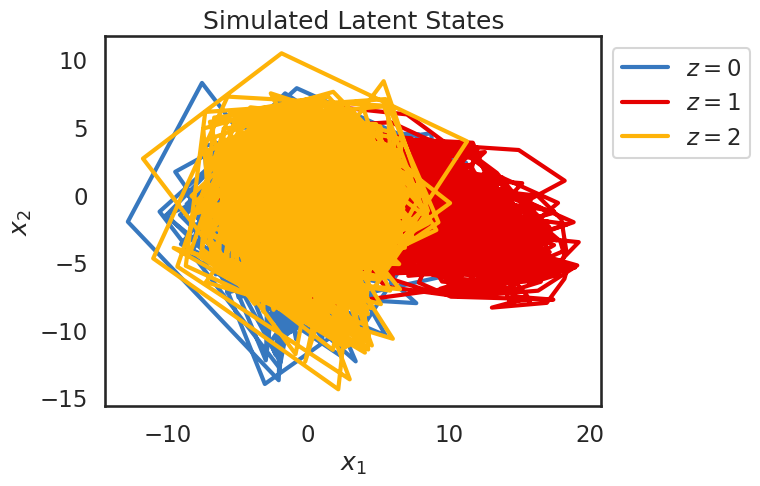

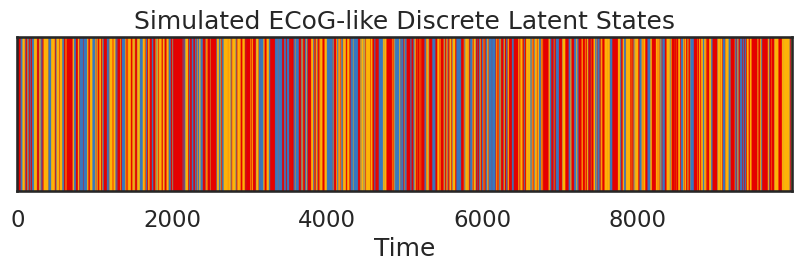

In [41]:
for k in range(n_disc_states):
    curr_states = x_true[z_true == k]
    plt.plot(curr_states[:,0],
             curr_states[:,1],
             '-',
             color=colors[k],
             lw=3,
             label="$z=%i$" % k)
    
    # Draw lines connecting the latent state between discrete state transitions,
    # so they don't show up as broken lines.
    next_states = x_true[z_true == k + 1]
    if len(next_states) > 0 and len(curr_states) > 0:
        plt.plot((curr_states[-1,0], next_states[0,0]),
                 (curr_states[-1,1], next_states[0,1]),
                 '-',
                 color='gray',
                 lw=1)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

plt.figure(figsize=(10,2))
cmap_limited = ListedColormap(colors[0:n_disc_states])
plt.imshow(z_true[None,:],  aspect="auto", cmap=cmap_limited)
plt.title("Simulated ECoG-like Discrete Latent States")
plt.yticks([])
plt.xlabel("Time")
plt.show()

## Fit a new SLDS to the observation(ECoG) data

In [42]:
ecog_like_slds = ssm.SLDS(n_elec,
                    n_disc_states,
                    latent_dim,
                    emissions = "gaussian_orthog")
elbos, posterior = ecog_like_slds.fit(y, 
                                      method = "laplace_em", 
                                      variational_posterior = "structured_meanfield",
                                      num_iters = 100)

# Get the posterior mean of the continuous state
elbos_x = posterior.mean_continuous_states[0]
print(elbos_x.shape)

# Find the permutation that matches the true and inferred states
ecog_like_slds.permute(find_permutation(z_true, ecog_like_slds.most_likely_states(elbos_x, y)))
elbos_z = ecog_like_slds.most_likely_states(elbos_x, y)

elbos_y = ecog_like_slds.smooth(elbos_x, y)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(10000, 2)


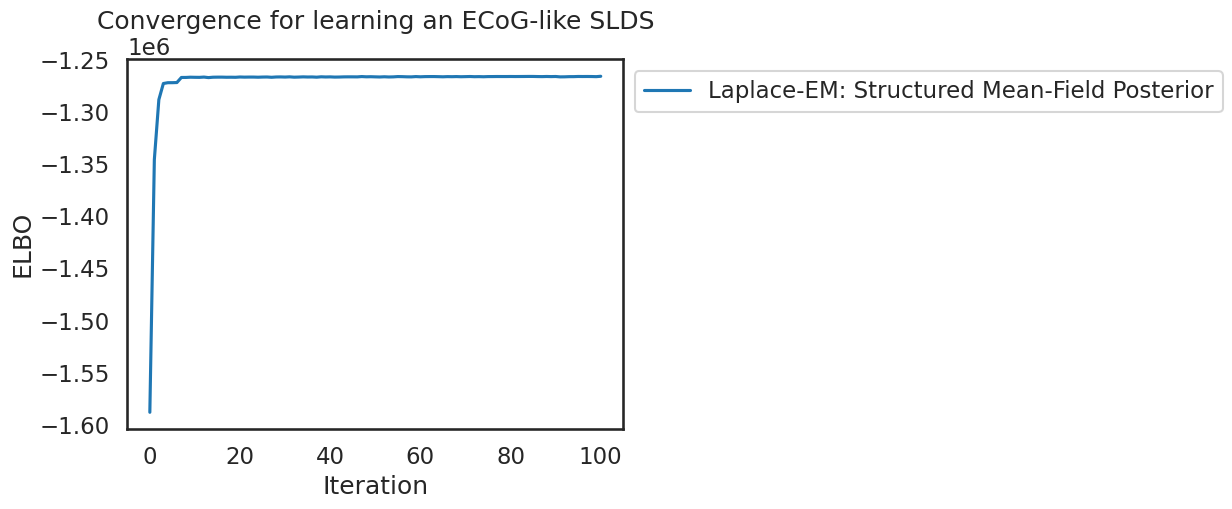

In [43]:
# Plot the ELBOs
plt.plot(elbos, label="Laplace-EM: Structured Mean-Field Posterior")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.title("Convergence for learning an ECoG-like SLDS")
plt.show()

## Visualize True and Inferred Latent States

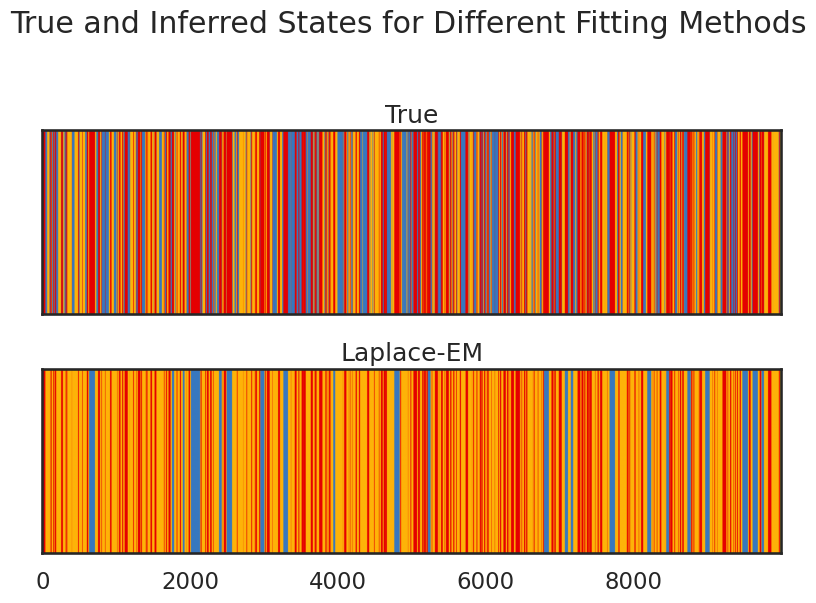

In [44]:
# Plot the true and inferred states
titles = ["True", "Laplace-EM",]
states_list = [z_true, elbos_z]
fig, axs = plt.subplots(2,1, figsize=(8,6))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_title(titles[i])
    if i < (len(axs) - 1):
        ax.set_xticks([])

plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()

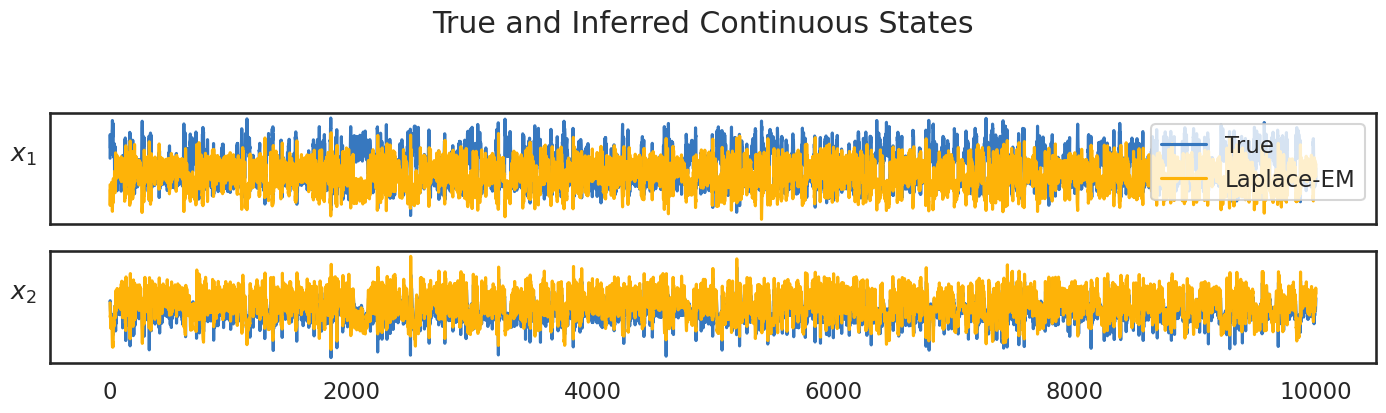

In [45]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(x_true[:,d] + 4 * d, '-', color=colors[0], label="True" if d==0 else None)
    ax.plot(elbos_x[:,d] + 4 * d, '-', color=colors[2], label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("True and Inferred Continuous States", va="bottom")
plt.tight_layout()

# Testing SLDS with real ECoG data now

In [46]:
import sys
sys.path.append("/scratch/pl2820/ecog_slds")

import numpy as np
import ssm
from data import EcogTaskPreProcessing


### Load ECoG data

In [47]:
subj = "NY742"
tasks = ["AudRep", "PicN", "VisRead"]
subj_dir = f"/scratch/pl2820/ecog_slds/Data/{subj}"

epoch_start = -256  # -0.5 sec before stim onset # ds 230 Hz
epoch_end = 1024  # 2 sec after stim onset
flag_response_lock = False
normalization_mode = "MultiBandHG"
flag_clean_time_before_zscore = True
number_log_dist_bands = 4

ecogdata = {}
for task in tasks:
    EP = EcogTaskPreProcessing(subj, task,
                               subj_dir = subj_dir, 
                               epoch_start = epoch_start,
                               epoch_end = epoch_end,
                               flag_response_lock = flag_response_lock,
                               normalization_mode = normalization_mode,
                               flag_clean_time_before_zscore = flag_clean_time_before_zscore,
                               number_log_dist_bands = number_log_dist_bands)
    trial_data, coords = EP.get_ecogdata()
    print(f"loaded data for task: {task}, {trial_data.shape}")
    ecogdata[task] = trial_data[:128,...]

loading data for subject: NY742 tasks: AudRep
loading /scratch/pl2820/ecog_slds/Data/NY742/data/AudRep/gdat_CAR.mat
preprocessing ...
loading events and running auto epoch ...
loading csv...
loaded data for task: AudRep, (172, 100, 1280)
loading data for subject: NY742 tasks: PicN
loading /scratch/pl2820/ecog_slds/Data/NY742/data/PicN/gdat_CAR.mat
preprocessing ...
loading events and running auto epoch ...
loading csv...
loaded data for task: PicN, (172, 100, 1280)
loading data for subject: NY742 tasks: VisRead
loading /scratch/pl2820/ecog_slds/Data/NY742/data/VisRead/gdat_CAR.mat
preprocessing ...
loading events and running auto epoch ...
loading csv...
loaded data for task: VisRead, (172, 100, 1280)


In [48]:
for task in tasks:
    print(f"{task}: {ecogdata[task].shape}")

AudRep: (128, 100, 1280)
PicN: (128, 100, 1280)
VisRead: (128, 100, 1280)


## Try fitting only one task in SLDS

In [49]:
# Trial-average and transpose to (T, N)
# This is the oberserved data(target data)
y1 = ecogdata["AudRep"].mean(axis=1).T  # (1280, 128)
print(f"SLDS input shape: {y1.shape}")

SLDS input shape: (1280, 128)


In [50]:
n1_disc_state = 3 # discrete states
latent_dim_1 = 3 # latent dimensions
n1_elec = 128 # electrodes

# Create the model
slds_1_task = ssm.SLDS(n1_elec,
                       n1_disc_state,
                       latent_dim_1,
                       emissions = "gaussian_orthog")

# fit the model
elbos_1, posterior_1 = slds_1_task.fit(y1,
                                       method = "laplace_em",
                                       variational_posterior = "structured_meanfield",
                                       num_iters = 100)

# Get the posterior mean of the continuous state
elbos_x1 = posterior_1.mean_continuous_states[0] # (1280, 3) continuous latent
print(elbos_x1.shape)

# No need to find permutation for real-world data because we don't know the exact lable?
elbos_z1 = slds_1_task.most_likely_states(elbos_x1, y1) # (1280, ) discrete state labels

elbos_y1 = slds_1_task.smooth(elbos_x1, y1)

print(f"Latent states shape: {elbos_x1.shape}")
print(f"Discrete states shape: {elbos_y1.shape}")
print(f"Unique states found: {np.unique(elbos_z1)}")

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(1280, 3)
Latent states shape: (1280, 3)
Discrete states shape: (1280, 128)
Unique states found: [0 1 2]


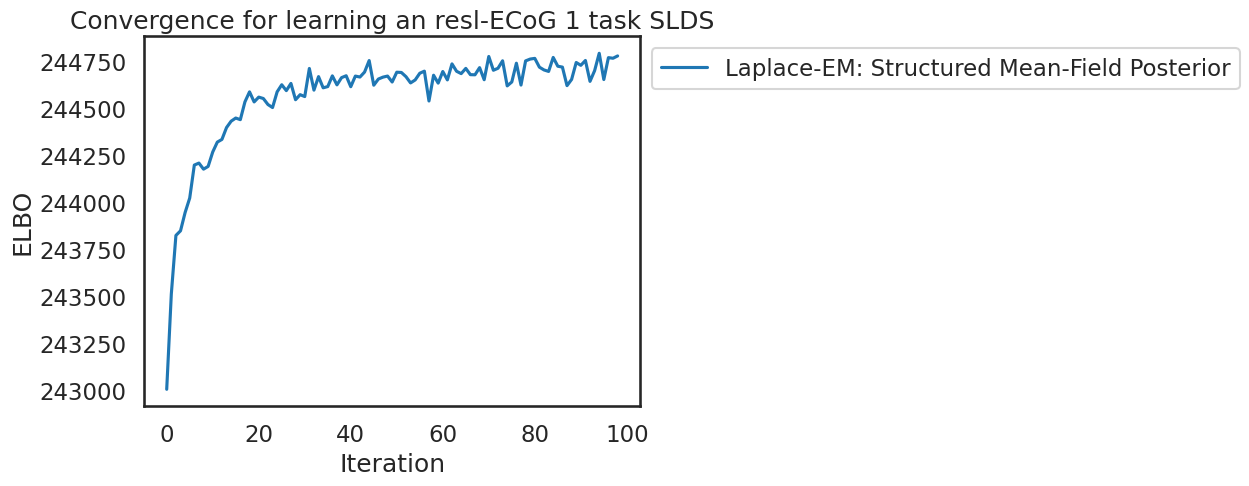

In [51]:
# Plot the ELBOs
plt.plot(elbos_1[2:], label="Laplace-EM: Structured Mean-Field Posterior")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.title("Convergence for learning an resl-ECoG 1 task SLDS")
plt.show()

Saved slds_AudRep_result.png


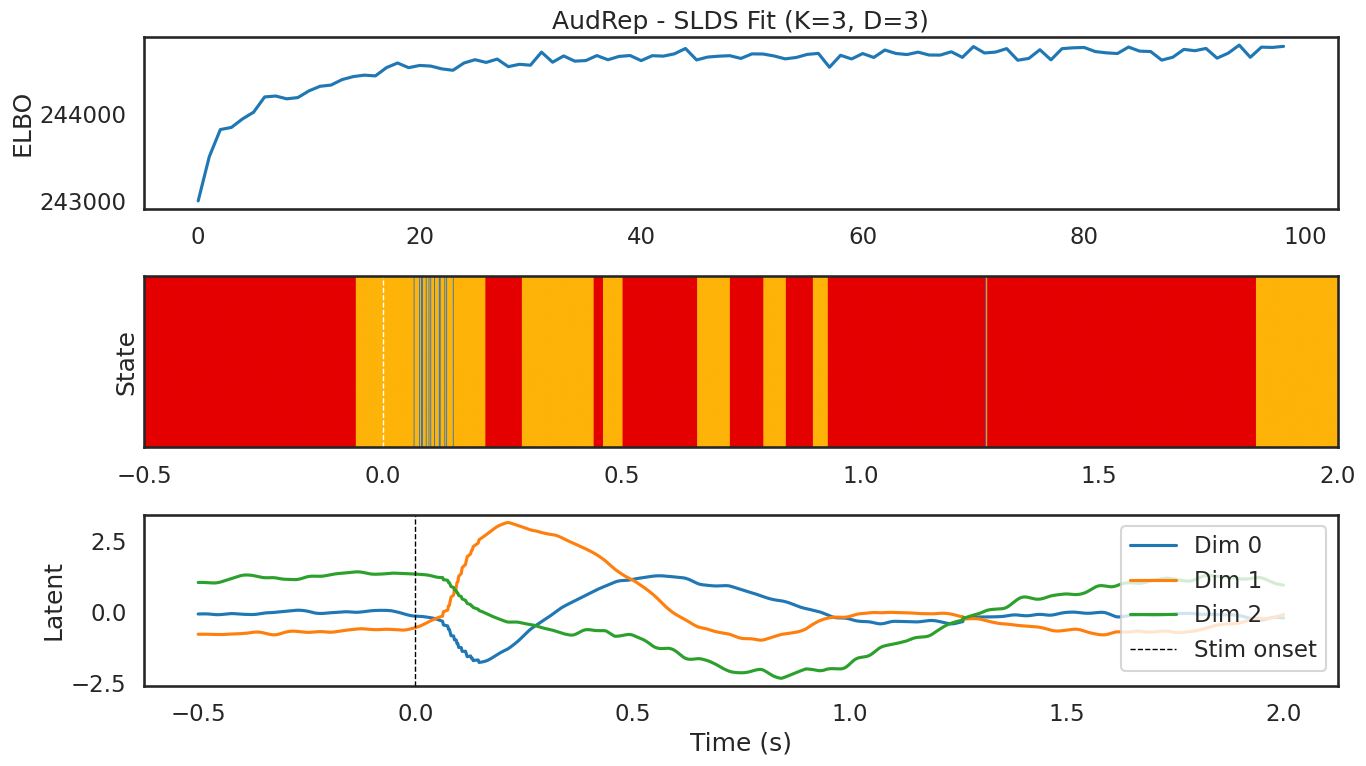

In [52]:
T = np.linspace(-0.5, 2.0, 1280)  # time axis in seconds

fig, axes = plt.subplots(3, 1, figsize=(14, 8))

# ELBO convergence
axes[0].plot(elbos_1[2:])
axes[0].set_ylabel("ELBO")
axes[0].set_title("AudRep - SLDS Fit (K=3, D=3)")

# Discrete states
axes[1].imshow(elbos_z1[None, :], aspect="auto", cmap = cmap_limited,
               extent=[T[0], T[-1], 0, 1])
axes[1].set_ylabel("State")
axes[1].set_yticks([])
axes[1].axvline(0, color='white', linestyle='--', linewidth=1)  # stim onset

# Latent trajectories
for d in range(latent_dim_1):
    axes[2].plot(T, elbos_x1[:, d], label=f"Dim {d}")
axes[2].axvline(0, color='k', linestyle='--', linewidth=1, label="Stim onset")
axes[2].set_ylabel("Latent")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

fig.tight_layout()
plt.savefig("slds_AudRep_result.png", dpi=150)
print("Saved slds_AudRep_result.png")


## Try fitting on all 3 task in SLDS

In [53]:
# Trial-average each task, transpose to (T, N)
y_list = []

for task in tasks:
    y_task = ecogdata[task].mean(axis = 1).T # (1280, 128)
    y_list.append(y_task)
    print(f"{task}: {y_task.shape}")

AudRep: (1280, 128)
PicN: (1280, 128)
VisRead: (1280, 128)


In [54]:
n3_disc_state = len(tasks)
latent_dim_3 = 6 # latent dimensions
n3_elec = 128 # electrodes

slds_all = ssm.SLDS(n3_elec,
                    n3_disc_state,
                    latent_dim_3,
                    emissions = "gaussian_orthog")
print("Fitting SLDS on all 3 tasks...")
# fit the model
elbos_all, posterior_all = slds_all.fit(y_list,
                                        method = "laplace_em",
                                        variational_posterior = "structured_meanfield",
                                        num_iters = 200)

Fitting SLDS on all 3 tasks...


  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

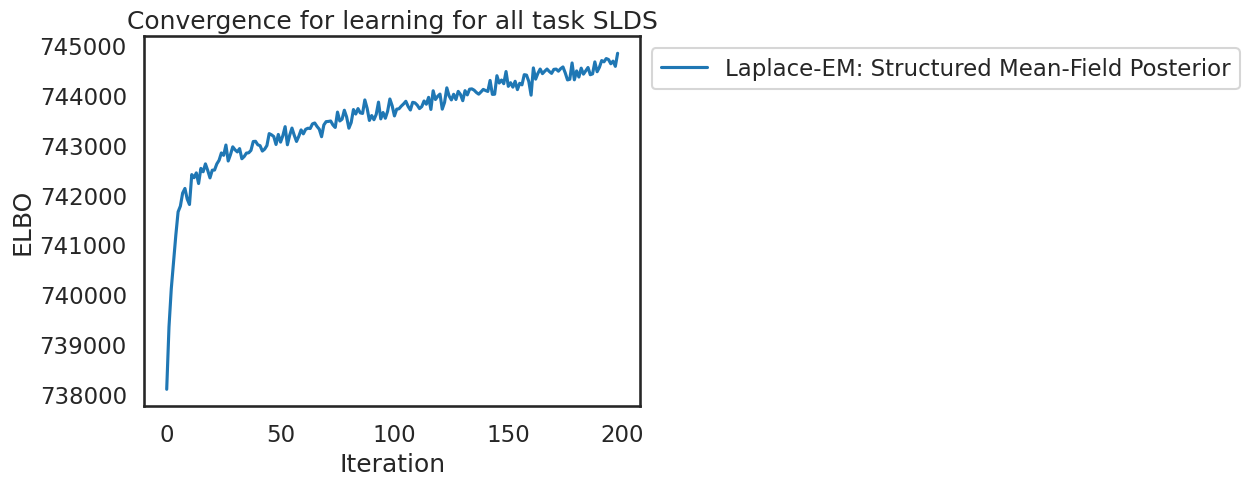

In [55]:
# Plot the ELBOs
plt.plot(elbos_all[2:], label="Laplace-EM: Structured Mean-Field Posterior")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.title("Convergence for learning for all task SLDS")
plt.show()

### Extract results per task

In [56]:
# posterior_all.mean_continuous_states is a list of 3 arrays (one per task)
elbos_x_all = [posterior_all.mean_continuous_states[i] for i in range(len(tasks))]  # 2D latent trajectory
elbos_z_all = [slds_all.most_likely_states(elbos_x_all[i], y_list[i]) for i in range(len(tasks))]
elbos_y_smooth = [slds_all.smooth(elbos_x_all[i], y_list[i]) for i in range(len(tasks))]

for i, task in enumerate(tasks):
    print(f"{task}: latent = {elbos_x_all[i].shape}, elbos_z_all = {elbos_z_all[i].shape}, states = {np.unique(elbos_z_all[i])}")

AudRep: latent = (1280, 6), elbos_z_all = (1280,), states = [0 1 2]
PicN: latent = (1280, 6), elbos_z_all = (1280,), states = [0 1 2]
VisRead: latent = (1280, 6), elbos_z_all = (1280,), states = [0 1 2]


Saved slds_all_tasks_result.png


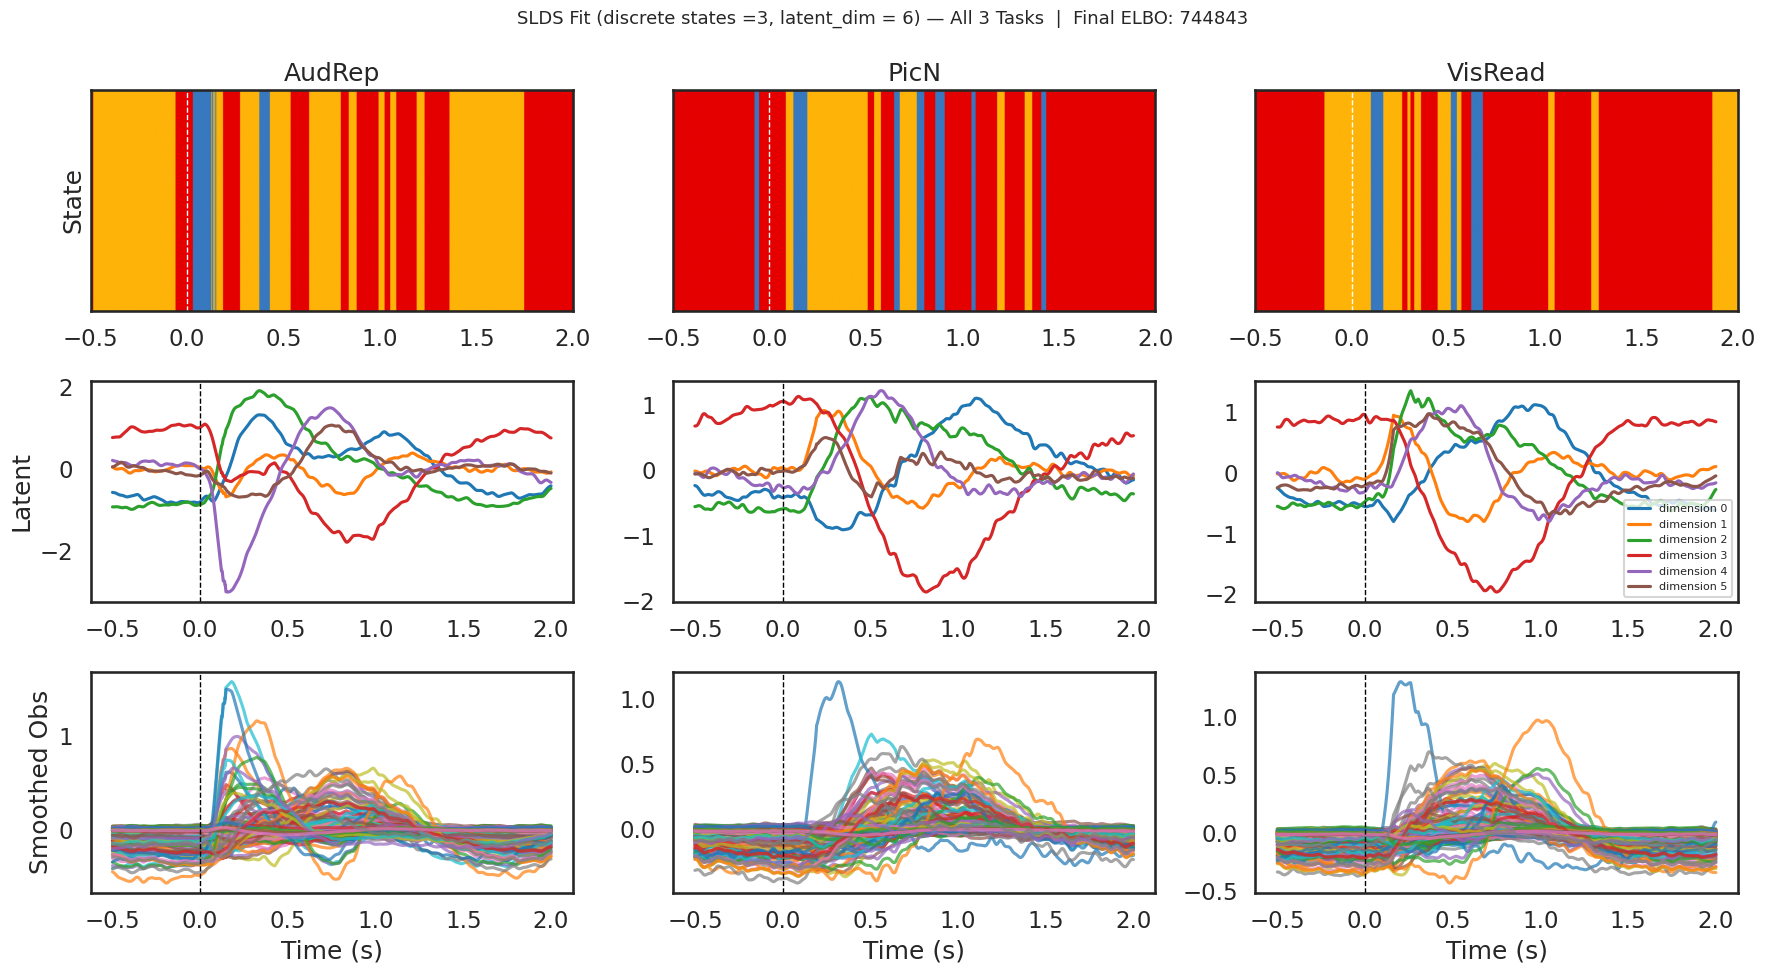

In [57]:
T = np.linspace(-0.5, 2.0, 1280)

fig, axes = plt.subplots(3, 3, figsize = (18, 10))

for col, task in enumerate(tasks):
    # Row 0: Discrete states
    axes[0, col].imshow(elbos_z_all[col][None, :], aspect = "auto", cmap = cmap_limited,
                        extent = [T[0], T[-1], 0, 1])
    axes[0, col].set_title(task)
    axes[0, col].set_yticks([])
    axes[0, col].axvline(0, color = 'white', linestyle = '--', linewidth = 1)
    if col == 0:
        axes[0, col].set_ylabel("State")

    # Row 1: Latent trajectories
    for x in range(latent_dim_3):
        axes[1, col].plot(T, elbos_x_all[col][:, x], label = f"dimension {x}")
    axes[1, col].axvline(0, color = 'k', linestyle = '--', linewidth = 1)
    if col == 0:
        axes[1, col].set_ylabel("Latent")
    if col == 2:
        axes[1, col].legend(fontsize = 8)

    # Row 2: Smoothed observations (first 5 electrodes)
    for e in range(128):
        axes[2, col].plot(T, elbos_y_smooth[col][:, e], alpha = 0.7)
    axes[2, col].axvline(0, color = 'k', linestyle = '--', linewidth = 1)
    axes[2, col].set_xlabel("Time (s)")
    if col == 0:
        axes[2, col].set_ylabel("Smoothed Obs")

# ELBO as a separate small plot on top
fig.suptitle(f"SLDS Fit (discrete states ={n3_disc_state}, latent_dim = {latent_dim_3}) — All 3 Tasks  |  Final ELBO: {elbos_all[-1]:.0f}", fontsize=13)
fig.tight_layout()
plt.savefig("slds_all_tasks_result.png", dpi=150)
print("Saved slds_all_tasks_result.png")

Saved slds_3d_latent.png


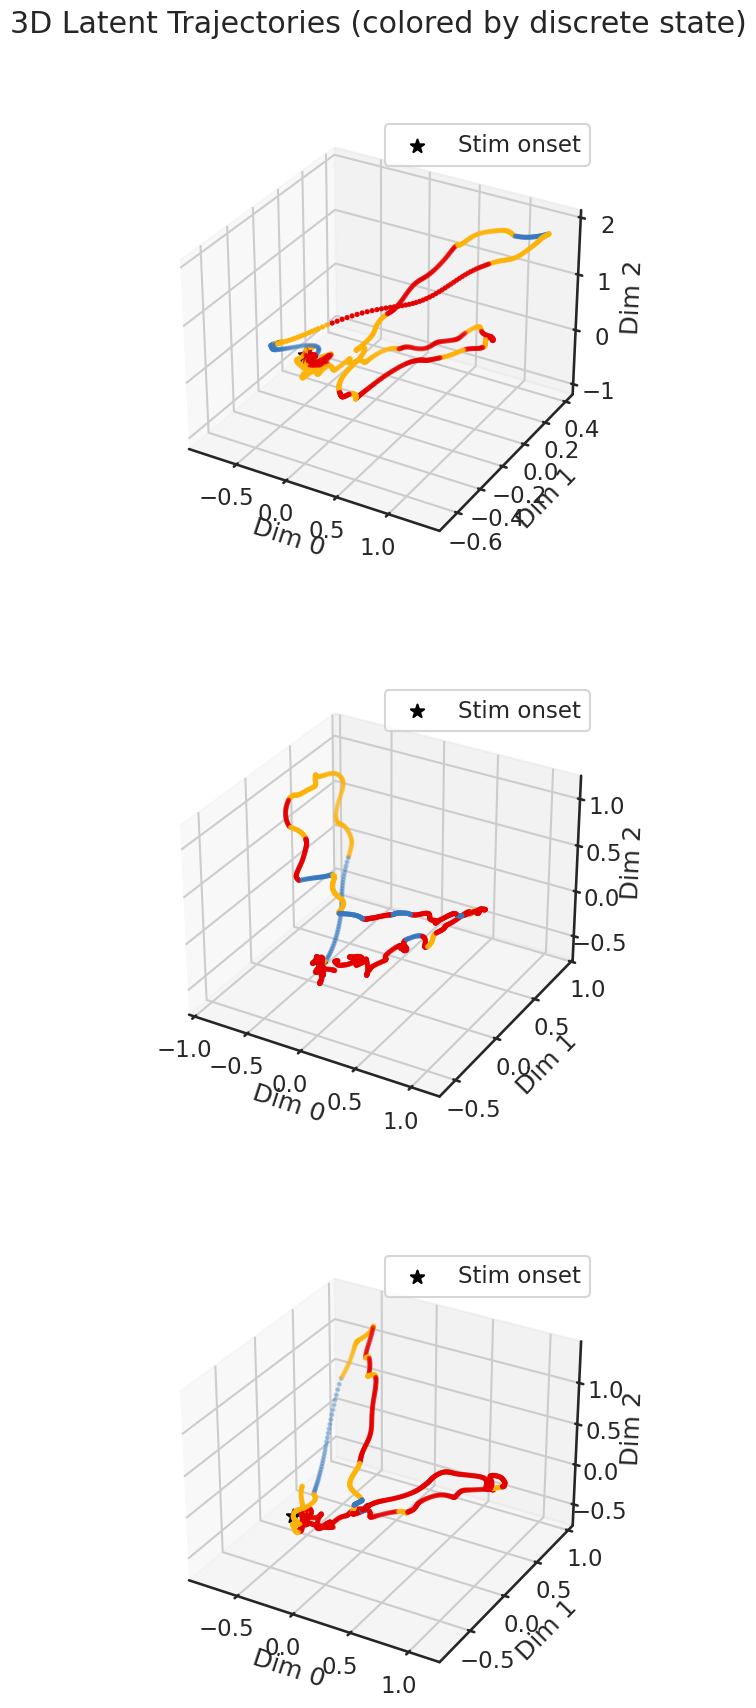

In [58]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (5, 18))

for i, task in enumerate(tasks):
    ax = fig.add_subplot(3, 1, i + 1, projection = '3d')
    x = elbos_x_all[i]

    # Color each point by its discrete state
    ax.scatter(x[:, 0], x[:, 1], x[:, 2],
                c = elbos_z_all[i], cmap = cmap_limited, s = 5)
    # Mark stimulus onset
    stim_idx = np.argmin(np.abs(T - 0.0)) # index close to t = 0
    ax.scatter(x[stim_idx, 0], x[stim_idx, 1], x[stim_idx, 2],
                c = 'black', s = 100, marker = '*', label = 'Stim onset')
    ax.set_xlabel("Dim 0")
    ax.set_ylabel("Dim 1")
    ax.set_zlabel("Dim 2")
    ax.legend()

fig.suptitle("3D Latent Trajectories (colored by discrete state)")
fig.tight_layout()
plt.savefig("slds_3d_latent.png", dpi = 150)
print("Saved slds_3d_latent.png")

---
---

# Part 2: Deeper Analysis of the SLDS Fit

Now that we have an SLDS fitted on all 3 conditions jointly, we can dig into:

1. **Posterior State Decoding & Visualization** — What do the discrete states *mean*?
2. **Comparing Dynamics Across Conditions** — How do the state-specific dynamics differ?
3. **Multi-Lag Comparison** — Does adding more temporal history help?
4. **Cross-Condition Generalization** — Can a model fit on one task predict another?

## 1. Posterior State Decoding & Visualization

### What is posterior state decoding?

When we fit an SLDS, we recover:
- **Continuous latent states** $x_t \in \mathbb{R}^D$ — a low-dimensional trajectory
- **Discrete latent states** $z_t \in \{0, 1, \ldots, K-1\}$ — which dynamical regime is active

The **posterior state decoding** asks: *given the observed data and the fitted model, what is the most likely sequence of discrete states?*

There are two approaches:
- **Marginal decoding** (forward-backward): compute $p(z_t = k \mid y_{1:T})$ independently for each $t$. Gives a **soft** assignment (probabilities).
- **Viterbi decoding** (`most_likely_states`): find the single most likely *sequence* $\arg\max_{z_{1:T}} p(z_{1:T} \mid y_{1:T})$. Gives a **hard** assignment.

We already computed Viterbi decoding above (`elbos_z_all`). Now let's visualize what these states actually capture by overlaying them on the raw signals.

### Why this matters for ECoG
The discrete states should correspond to distinct **dynamical regimes** during the task — e.g., pre-stimulus baseline, stimulus processing, response preparation. Seeing *when* the model switches states relative to task events tells us whether the model captures meaningful neural dynamics.

In [ ]:
# ============================================================
# Posterior State Decoding: States overlaid on latent trajectories
# ============================================================
T = np.linspace(-0.5, 2.0, 1280)

fig, axes = plt.subplots(len(tasks), 2, figsize=(18, 3.5 * len(tasks)),
                         gridspec_kw={'width_ratios': [3, 1]})

for i, task in enumerate(tasks):
    z = elbos_z_all[i]
    x = elbos_x_all[i]
    
    # Left: latent trajectories with state background shading
    ax = axes[i, 0]
    for d in range(min(latent_dim_3, 4)):  # plot first 4 dims
        ax.plot(T, x[:, d], label=f"Dim {d}", alpha=0.8)
    
    # Shade background by discrete state
    for t_idx in range(len(T) - 1):
        ax.axvspan(T[t_idx], T[t_idx + 1], alpha=0.15,
                   color=colors[z[t_idx]], linewidth=0)
    
    ax.axvline(0, color='k', linestyle='--', linewidth=1.5, label="Stim onset")
    ax.set_ylabel("Latent value")
    ax.set_title(f"{task} — Latent trajectories with state overlay")
    if i == 0:
        ax.legend(fontsize=7, ncol=5, loc='upper right')
    if i == len(tasks) - 1:
        ax.set_xlabel("Time (s)")
    
    # Right: state sequence as colored bar + state probability
    ax2 = axes[i, 1]
    state_times = []
    for k in range(n3_disc_state):
        mask = (z == k)
        frac = mask.sum() / len(z)
        state_times.append(frac)
    ax2.barh(range(n3_disc_state), state_times, color=[colors[k] for k in range(n3_disc_state)])
    ax2.set_yticks(range(n3_disc_state))
    ax2.set_yticklabels([f"State {k}" for k in range(n3_disc_state)])
    ax2.set_xlabel("Fraction of time")
    ax2.set_title("State occupancy")
    ax2.set_xlim(0, 1)

fig.tight_layout()

In [ ]:
# ============================================================
# Transition matrices and dwell-time analysis per condition
# ============================================================

fig, axes = plt.subplots(2, len(tasks), figsize=(5 * len(tasks), 8))

for i, task in enumerate(tasks):
    z = elbos_z_all[i]
    
    # --- Row 0: Empirical transition matrix ---
    # Count transitions between states
    trans_counts = np.zeros((n3_disc_state, n3_disc_state))
    for t in range(len(z) - 1):
        trans_counts[z[t], z[t + 1]] += 1
    # Normalize rows
    row_sums = trans_counts.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # avoid division by zero
    trans_matrix = trans_counts / row_sums
    
    ax = axes[0, i]
    im = ax.imshow(trans_matrix, vmin=0, vmax=1, cmap="Blues")
    for r in range(n3_disc_state):
        for c in range(n3_disc_state):
            ax.text(c, r, f"{trans_matrix[r, c]:.2f}", ha='center', va='center', fontsize=10)
    ax.set_xlabel("Next state")
    ax.set_ylabel("Current state")
    ax.set_title(f"{task}\nEmpirical transition matrix")
    ax.set_xticks(range(n3_disc_state))
    ax.set_yticks(range(n3_disc_state))
    
    # --- Row 1: Dwell time histogram ---
    ax2 = axes[1, i]
    dwell_times = {k: [] for k in range(n3_disc_state)}
    current_state = z[0]
    current_dwell = 1
    for t in range(1, len(z)):
        if z[t] == current_state:
            current_dwell += 1
        else:
            dwell_times[current_state].append(current_dwell)
            current_state = z[t]
            current_dwell = 1
    dwell_times[current_state].append(current_dwell)
    
    dt = (T[1] - T[0]) * 1000  # convert to ms
    for k in range(n3_disc_state):
        if len(dwell_times[k]) > 0:
            dwells_ms = np.array(dwell_times[k]) * dt
            ax2.hist(dwells_ms, bins=15, alpha=0.6, color=colors[k],
                     label=f"State {k} (mean={dwells_ms.mean():.0f}ms)")
    ax2.set_xlabel("Dwell time (ms)")
    ax2.set_ylabel("Count")
    ax2.set_title(f"{task}\nDwell time distribution")
    ax2.legend(fontsize=8)

fig.tight_layout()

In [ ]:
# ============================================================
# State timing: When does each state occur relative to stimulus onset?
# ============================================================

fig, axes = plt.subplots(1, len(tasks), figsize=(6 * len(tasks), 4), sharey=True)

for i, task in enumerate(tasks):
    z = elbos_z_all[i]
    ax = axes[i]
    
    for k in range(n3_disc_state):
        state_mask = (z == k).astype(float)
        ax.fill_between(T, k, k + state_mask, alpha=0.7, color=colors[k],
                        label=f"State {k}")
    
    ax.axvline(0, color='k', linestyle='--', linewidth=2, label="Stim onset")
    ax.set_xlabel("Time (s)")
    ax.set_title(task)
    ax.set_yticks([0.5 + k for k in range(n3_disc_state)])
    ax.set_yticklabels([f"State {k}" for k in range(n3_disc_state)])
    if i == 0:
        ax.set_ylabel("Active state")

axes[-1].legend(fontsize=8, loc='upper right')
fig.suptitle("State activation timeline per condition", fontsize=14)
fig.tight_layout()

## 2. Compare Inferred Dynamics Across Conditions

### What are the dynamics matrices?

In the SLDS, each discrete state $k$ defines a **linear dynamical system** in the latent space:

$$x_t = A_k x_{t-1} + b_k + w_t, \quad w_t \sim \mathcal{N}(0, Q_k)$$

The key parameters are:
- **$A_k$** (dynamics matrix): How the latent state evolves. Its **eigenvalues** tell us about the dynamics:
  - $|\lambda| < 1$: stable, decaying dynamics (latent state contracts)
  - $|\lambda| \approx 1$: persistent dynamics (latent state maintains)
  - Complex eigenvalues: **oscillatory** dynamics (frequency $\propto \arg(\lambda)$)
- **$b_k$** (bias): The attractor point. If $A_k$ is stable, the latent state spirals toward $(I - A_k)^{-1} b_k$
- **$Q_k$** (noise covariance): How "stochastic" the dynamics are within each regime

### Why compare across conditions?

Since we fit a **single** SLDS to all 3 conditions, the dynamics matrices $A_k$ and transition matrix are **shared**. The differences between conditions show up in:
1. **Which states are visited** and for **how long** (already visualized above)
2. **When** state transitions happen relative to task events
3. The **continuous latent trajectories** within each state

This tells us whether different cognitive tasks drive the same brain through the same dynamical regimes in different temporal patterns.

In [ ]:
# ============================================================
# Extract and analyze the shared dynamics matrices
# ============================================================

# The dynamics are shared across conditions (single model)
As = slds_all.dynamics.As   # (K, D, D*lags) — dynamics matrices
bs = slds_all.dynamics.bs   # (K, D) — biases
Sigmas = slds_all.dynamics.Sigmas  # (K, D, D) — noise covariances

print("=== Dynamics parameters (shared across all conditions) ===")
print(f"A_k shape: {As.shape}  — (K={n3_disc_state}, D={latent_dim_3}, D*lags={As.shape[2]})")
print(f"b_k shape: {bs.shape}")
print(f"Σ_k shape: {Sigmas.shape}")

# Eigenvalue analysis
print("\n=== Eigenvalue analysis per state ===")
for k in range(n3_disc_state):
    A_k = As[k][:, :latent_dim_3]  # first lag block (D x D)
    eigs = np.linalg.eigvals(A_k)
    mags = np.abs(eigs)
    freqs = np.angle(eigs) / (2 * np.pi)  # cycles per timestep
    
    print(f"\nState {k}:")
    print(f"  Eigenvalue magnitudes: {np.sort(mags)[::-1].round(3)}")
    print(f"  Max |λ| = {mags.max():.4f} ({'stable' if mags.max() < 1 else 'UNSTABLE'})")
    print(f"  Oscillatory modes: {(np.abs(eigs.imag) > 1e-6).sum()} complex eigenvalues")

In [ ]:
# ============================================================
# Visualize eigenvalues on the complex plane + dynamics matrices as heatmaps
# ============================================================

fig, axes = plt.subplots(1, n3_disc_state + 1, figsize=(4 * (n3_disc_state + 1), 4))

# Plot eigenvalues on the unit circle for each state
for k in range(n3_disc_state):
    ax = axes[k]
    A_k = As[k][:, :latent_dim_3]
    eigs = np.linalg.eigvals(A_k)
    
    # Draw unit circle
    theta_circle = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', alpha=0.3, linewidth=1)
    
    # Plot eigenvalues
    ax.scatter(eigs.real, eigs.imag, s=100, color=colors[k], zorder=5, edgecolors='k')
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_aspect('equal')
    ax.set_title(f"State {k}\nmax|λ|={np.abs(eigs).max():.3f}")
    ax.set_xlabel("Real")
    if k == 0:
        ax.set_ylabel("Imaginary")

# Last panel: learned transition matrix
ax = axes[-1]
P = slds_all.transitions.transition_matrix
im = ax.imshow(P, vmin=0, vmax=1, cmap="Blues")
for r in range(n3_disc_state):
    for c in range(n3_disc_state):
        ax.text(c, r, f"{P[r, c]:.2f}", ha='center', va='center', fontsize=11)
ax.set_xlabel("Next state")
ax.set_ylabel("Current state")
ax.set_title("Learned transition\nmatrix P")
ax.set_xticks(range(n3_disc_state))
ax.set_yticks(range(n3_disc_state))
plt.colorbar(im, ax=ax, shrink=0.7)

fig.suptitle("Eigenvalue spectra of dynamics matrices (inside unit circle = stable)", fontsize=13)
fig.tight_layout()

In [ ]:
# ============================================================
# Dynamics matrices as heatmaps + state-conditioned latent speed
# ============================================================

fig, axes = plt.subplots(2, n3_disc_state, figsize=(5 * n3_disc_state, 8))

for k in range(n3_disc_state):
    # Row 0: A_k heatmap
    ax = axes[0, k]
    A_k = As[k][:, :latent_dim_3]
    im = ax.imshow(A_k, cmap="RdBu_r", vmin=-1, vmax=1)
    ax.set_title(f"State {k}: $A_k$")
    ax.set_xlabel("Input dim")
    ax.set_ylabel("Output dim")
    plt.colorbar(im, ax=ax, shrink=0.7)
    
    # Row 1: latent velocity (||x_t - x_{t-1}||) conditioned on each state, per task
    ax2 = axes[1, k]
    for i, task in enumerate(tasks):
        z = elbos_z_all[i]
        x = elbos_x_all[i]
        velocities = np.linalg.norm(np.diff(x, axis=0), axis=1)
        state_mask = (z[1:] == k)
        if state_mask.sum() > 0:
            state_vels = velocities[state_mask]
            ax2.hist(state_vels, bins=20, alpha=0.5, label=f"{task} (n={state_mask.sum()})",
                     density=True)
    ax2.set_xlabel("Latent velocity $||x_t - x_{t-1}||$")
    ax2.set_ylabel("Density")
    ax2.set_title(f"State {k}: velocity distribution")
    ax2.legend(fontsize=8)

fig.suptitle("Dynamics matrices and state-conditioned latent velocities", fontsize=13)
fig.tight_layout()

---

## 3. Multi-Lag Comparison

### Why try multiple lags?

The current model uses **lag-1** dynamics: $x_t = A_k x_{t-1} + b_k + w_t$.

With **lag-L** dynamics:
$$x_t = \sum_{\ell=1}^{L} A_k^{(\ell)} x_{t-\ell} + b_k + w_t$$

This matters because ECoG signals have temporal structure spanning multiple timesteps.
At 230 Hz (our downsampled rate), lag-1 captures ~4.3ms of history.
Lag-3 would capture ~13ms, which may better capture oscillatory dynamics.

### How to add lags in ssm

Simply pass `dynamics_kwargs=dict(lags=L)` when creating the SLDS:
```python
slds = ssm.SLDS(N, K, D,
                emissions="gaussian_orthog",
                dynamics_kwargs=dict(lags=2))
```

The dynamics weight matrix $A_k$ grows from shape `(D, D)` to `(D, D*L)`,
where columns `[0:D]` are lag-1 coefficients, `[D:2D]` are lag-2, etc.

### What to look for
- If adding lags **improves the ELBO**, the data has temporal structure beyond 1 step
- If the extra lag coefficients are **near zero**, lag-1 is sufficient
- More lags = more parameters = risk of overfitting on short time series

In [ ]:
# ============================================================
# Multi-lag comparison: fit SLDS with lags 1, 2, 3
# ============================================================

lag_values = [1, 2, 3]
lag_results = {}

for n_lags in lag_values:
    print(f"\n{'='*60}")
    print(f"Fitting SLDS with lags={n_lags}")
    print(f"{'='*60}")
    
    slds_lag = ssm.SLDS(n3_elec,
                        n3_disc_state,
                        latent_dim_3,
                        emissions="gaussian_orthog",
                        dynamics_kwargs=dict(lags=n_lags))
    
    print(f"  Dynamics weight shape: {slds_lag.dynamics.As.shape}  (K, D, D*lags)")
    
    elbos_lag, posterior_lag = slds_lag.fit(y_list,
                                            method="laplace_em",
                                            variational_posterior="structured_meanfield",
                                            num_iters=200)
    
    lag_results[n_lags] = {
        'model': slds_lag,
        'elbos': elbos_lag,
        'posterior': posterior_lag,
        'final_elbo': elbos_lag[-1]
    }
    print(f"  Final ELBO: {elbos_lag[-1]:.1f}")

In [ ]:
# ============================================================
# Compare ELBO convergence across lag orders
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: full convergence curves
ax = axes[0]
for n_lags, res in lag_results.items():
    ax.plot(res['elbos'][2:], label=f"lags={n_lags} (final: {res['final_elbo']:.0f})")
ax.set_xlabel("EM Iteration")
ax.set_ylabel("ELBO")
ax.legend()
ax.set_title("ELBO convergence for different lag orders")

# Right: bar chart of final ELBOs
ax2 = axes[1]
final_elbos = [lag_results[l]['final_elbo'] for l in lag_values]
bar_colors = [colors[i] for i in range(len(lag_values))]
bars = ax2.bar([f"lag-{l}" for l in lag_values], final_elbos, color=bar_colors)
ax2.set_ylabel("Final ELBO")
ax2.set_title("Final ELBO by lag order\n(higher is better)")

# Annotate bars
for bar, val in zip(bars, final_elbos):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.0f}', ha='center', va='bottom', fontsize=11)

fig.tight_layout()

In [ ]:
# ============================================================
# Inspect extra lag coefficients: are they meaningful or near zero?
# ============================================================

best_lag = max(lag_values)
if best_lag > 1 and best_lag in lag_results:
    W = lag_results[best_lag]['model'].dynamics.As
    D = latent_dim_3
    
    print(f"=== Lag coefficient norms for lag-{best_lag} model ===")
    print(f"Weight shape: {W.shape}  (K, D, D*{best_lag})")
    
    fig, axes = plt.subplots(1, n3_disc_state, figsize=(5 * n3_disc_state, 4))
    
    for k in range(n3_disc_state):
        norms = []
        labels = []
        for l in range(best_lag):
            W_lag = W[k][:, l*D:(l+1)*D]
            norm = np.linalg.norm(W_lag, 'fro')
            norms.append(norm)
            labels.append(f"Lag-{l+1}")
            print(f"  State {k}, Lag-{l+1}: ||W|| = {norm:.4f}")
        
        axes[k].bar(labels, norms, color=colors[k], alpha=0.7)
        axes[k].set_ylabel("Frobenius norm")
        axes[k].set_title(f"State {k}")
    
    fig.suptitle(f"Weight norms by lag order (lag-{best_lag} model)\nLarge lag-1 + small others → lag-1 is sufficient",
                 fontsize=12)
    fig.tight_layout()

---

## 4. Cross-Condition Generalization

### The idea

If we fit an SLDS on **one task** (e.g., AudRep), can the learned dynamics explain
the neural activity during a **different task** (e.g., PicN)?

This tests whether the dynamical regimes are **task-general** (shared across conditions)
or **task-specific** (unique to each condition).

### How it works

1. **Train**: Fit an SLDS on task A → learn dynamics $\{A_k, b_k, Q_k\}$, emissions $C$, transitions $P$
2. **Test**: For task B, hold model parameters **fixed** and only fit the variational posterior
   using `slds.approximate_posterior(y_B)` — this finds the best latent trajectory
   under the trained model
3. **Compare**: The ELBO on the held-out task tells us how well the model generalizes

- **High held-out ELBO** → the trained model explains the new data well → shared dynamics
- **Low held-out ELBO** → poor generalization → task-specific dynamics

In [ ]:
# ============================================================
# Step 1: Fit a separate SLDS on each individual task
# ============================================================

single_task_models = {}

for i, task in enumerate(tasks):
    print(f"\n{'='*60}")
    print(f"Fitting SLDS on {task} only")
    print(f"{'='*60}")
    
    slds_single = ssm.SLDS(n3_elec,
                           n3_disc_state,
                           latent_dim_3,
                           emissions="gaussian_orthog")
    
    elbos_single, posterior_single = slds_single.fit(
        y_list[i],
        method="laplace_em",
        variational_posterior="structured_meanfield",
        num_iters=200
    )
    
    single_task_models[task] = {
        'model': slds_single,
        'elbos': elbos_single,
        'posterior': posterior_single,
        'final_elbo': elbos_single[-1]
    }
    print(f"  Final ELBO (train): {elbos_single[-1]:.1f}")

In [ ]:
# ============================================================
# Step 2: Cross-condition evaluation using approximate_posterior
# Fit variational posterior on held-out data with model params FIXED
# ============================================================

cross_elbos = np.zeros((len(tasks), len(tasks)))  # [train_task, test_task]

for i, train_task in enumerate(tasks):
    model = single_task_models[train_task]['model']
    
    for j, test_task in enumerate(tasks):
        print(f"  Train: {train_task} → Test: {test_task} ...", end=" ")
        
        # Use approximate_posterior to evaluate on test data
        # This holds model params fixed, only fits the variational posterior
        test_elbos, test_posterior = model.approximate_posterior(
            y_list[j],
            method="laplace_em",
            variational_posterior="structured_meanfield",
            num_iters=50
        )
        
        cross_elbos[i, j] = test_elbos[-1]
        marker = " ← (self)" if i == j else ""
        print(f"ELBO = {test_elbos[-1]:.1f}{marker}")

print("\n=== Cross-condition ELBO matrix ===")
print(f"{'':>10}", end="")
for task in tasks:
    print(f"{task:>12}", end="")
print()
for i, train_task in enumerate(tasks):
    print(f"{train_task:>10}", end="")
    for j in range(len(tasks)):
        print(f"{cross_elbos[i, j]:>12.1f}", end="")
    print()

In [ ]:
# ============================================================
# Visualize cross-condition generalization matrix
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: ELBO heatmap
ax = axes[0]
im = ax.imshow(cross_elbos, cmap="YlOrRd")
ax.set_xticks(range(len(tasks)))
ax.set_xticklabels(tasks)
ax.set_yticks(range(len(tasks)))
ax.set_yticklabels(tasks)
ax.set_xlabel("Test task")
ax.set_ylabel("Train task")
ax.set_title("Cross-condition ELBO\n(higher = better generalization)")
for r in range(len(tasks)):
    for c in range(len(tasks)):
        ax.text(c, r, f"{cross_elbos[r, c]:.0f}", ha='center', va='center',
                fontsize=11, fontweight='bold' if r == c else 'normal')
plt.colorbar(im, ax=ax, shrink=0.8)

# Right: Normalized generalization (off-diagonal / diagonal)
ax2 = axes[1]
diag = np.diag(cross_elbos)
# For each train model, compute: held-out ELBO / self ELBO
# Values near 1 = good generalization
generalization_ratio = cross_elbos / diag[:, None]
im2 = ax2.imshow(generalization_ratio, cmap="RdYlGn", vmin=0.5, vmax=1.5)
ax2.set_xticks(range(len(tasks)))
ax2.set_xticklabels(tasks)
ax2.set_yticks(range(len(tasks)))
ax2.set_yticklabels(tasks)
ax2.set_xlabel("Test task")
ax2.set_ylabel("Train task")
ax2.set_title("Generalization ratio\n(ELBO_test / ELBO_self, ~1 = good)")
for r in range(len(tasks)):
    for c in range(len(tasks)):
        ax2.text(c, r, f"{generalization_ratio[r, c]:.2f}", ha='center', va='center',
                 fontsize=11, fontweight='bold' if r == c else 'normal')
plt.colorbar(im2, ax=ax2, shrink=0.8)

fig.tight_layout()

### Interpreting the cross-condition results

**Reading the ELBO matrix:**
- **Diagonal** entries = self-evaluation (train and test on same task). This is the "ceiling" performance.
- **Off-diagonal** entries = cross-evaluation (train on row, test on column).
- If off-diagonal values are **close to diagonal**, the learned dynamics generalize well across tasks.
- If off-diagonal values are **much lower**, the dynamics are task-specific.

**Generalization ratio:**
- Ratio of (cross-task ELBO) / (self ELBO)
- Values near **1.0** = excellent generalization (shared dynamics)
- Values **< 1.0** = poor generalization (task-specific dynamics)
- Asymmetries (A→B ≠ B→A) suggest one task's dynamics are a "subset" of another's

**What this tells us about ECoG:**
- If AudRep dynamics generalize to VisRead, it suggests shared sensory processing stages
- If they don't generalize, each task engages fundamentally different dynamical regimes
- This is a key scientific question: are cognitive state transitions task-general or task-specific?